In [ ]:
# Install Kaggle API
!pip install kaggle

# Upload kaggle.json
from google.colab import files
files.upload()  # Manually upload kaggle.json here

# Move kaggle.json to the correct directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [ ]:
# Download the dataset (replace with actual dataset name)
!kaggle datasets download -d dagnelies/deepfake-faces --unzip


Dataset URL: https://www.kaggle.com/datasets/dagnelies/deepfake-faces
License(s): other


In [ ]:
import os
os.listdir()


['.config', 'faces_224', 'metadata.csv', 'sample_data']

In [ ]:
import sys
import sklearn
import tensorflow as tf

import cv2
import pandas as pd
import numpy as np

import plotly.graph_objs as go
from plotly.offline import iplot
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [ ]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [ ]:
meta = pd.read_csv('metadata.csv')
meta

,videoname,original_width,original_height,label,original
0,aznyksihgl.mp4,129,129,FAKE,xnojggkrxt.mp4
1,gkwmalrvcj.mp4,129,129,FAKE,hqqmtxvbjj.mp4
2,lxnqzocgaq.mp4,223,217,FAKE,xjzkfqddyk.mp4
3,itsbtrrelv.mp4,186,186,FAKE,kqvepwqxfe.mp4
4,ddvgrczjno.mp4,155,155,FAKE,pluadmqqta.mp4
...,...,...,...,...,...
95629,rqcsjlsmiz.mp4,129,129,FAKE,pbsccacgff.mp4
95630,xjmnerypjf.mp4,90,90,FAKE,qrjydgidga.mp4
95631,hnewpzhihy.mp4,75,75,FAKE,vabhbfiifl.mp4
95632,okbarlnmwm.mp4,268,267,FAKE,uqaaspbgtz.mp4


In [ ]:
meta.shape

(95634, 5)

In [ ]:
len(meta[meta.label=='FAKE']),len(meta[meta.label=='REAL'])

(79341, 16293)

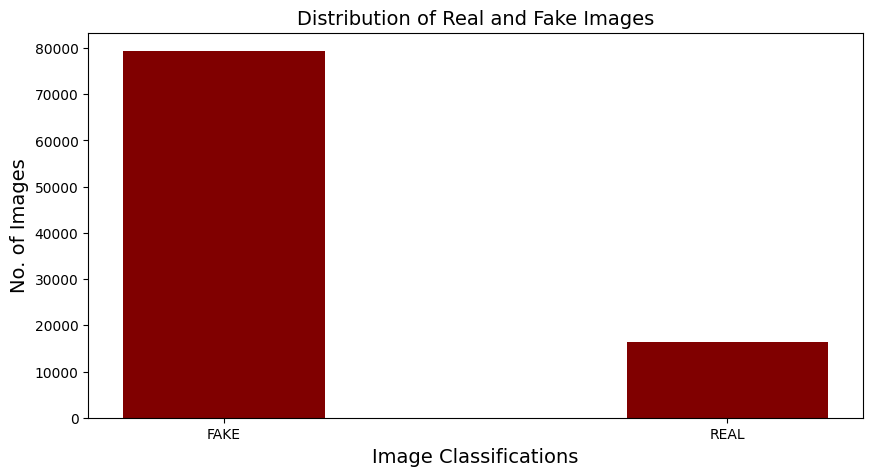

In [ ]:
fig = plt.figure(figsize = (10, 5))

plt.bar(list(meta['label'].unique()), list(meta['label'].value_counts().values), color ='maroon', width = 0.4)

plt.xlabel("Image Classifications")
plt.ylabel("No. of Images")
plt.title("Distribution of Real and Fake Images")
plt.show()

In [ ]:
real_df = meta[meta["label"] == "REAL"]
fake_df = meta[meta["label"] == "FAKE"]
sample_size = 8000

real_df = real_df.sample(sample_size, random_state=42)
fake_df = fake_df.sample(sample_size, random_state=42)

sample_meta = pd.concat([real_df, fake_df])

In [ ]:
from sklearn.model_selection import train_test_split

Train_set, Test_set = train_test_split(sample_meta,test_size=0.2,random_state=42,stratify=sample_meta['label'])
Train_set, Val_set  = train_test_split(Train_set,test_size=0.3,random_state=42,stratify=Train_set['label'])

In [ ]:
Train_set.shape,Val_set.shape,Test_set.shape

((8960, 5), (3840, 5), (3200, 5))

In [ ]:
y = dict()

y[0] = []
y[1] = []

for set_name in (np.array(Train_set['label']), np.array(Val_set['label']), np.array(Test_set['label'])):
    y[0].append(np.sum(set_name == 'REAL'))
    y[1].append(np.sum(set_name == 'FAKE'))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='REAL',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='FAKE',
    marker=dict(color='#ff3300'),
    opacity=0.7
)

data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)

fig = go.Figure(data, layout)
iplot(fig)

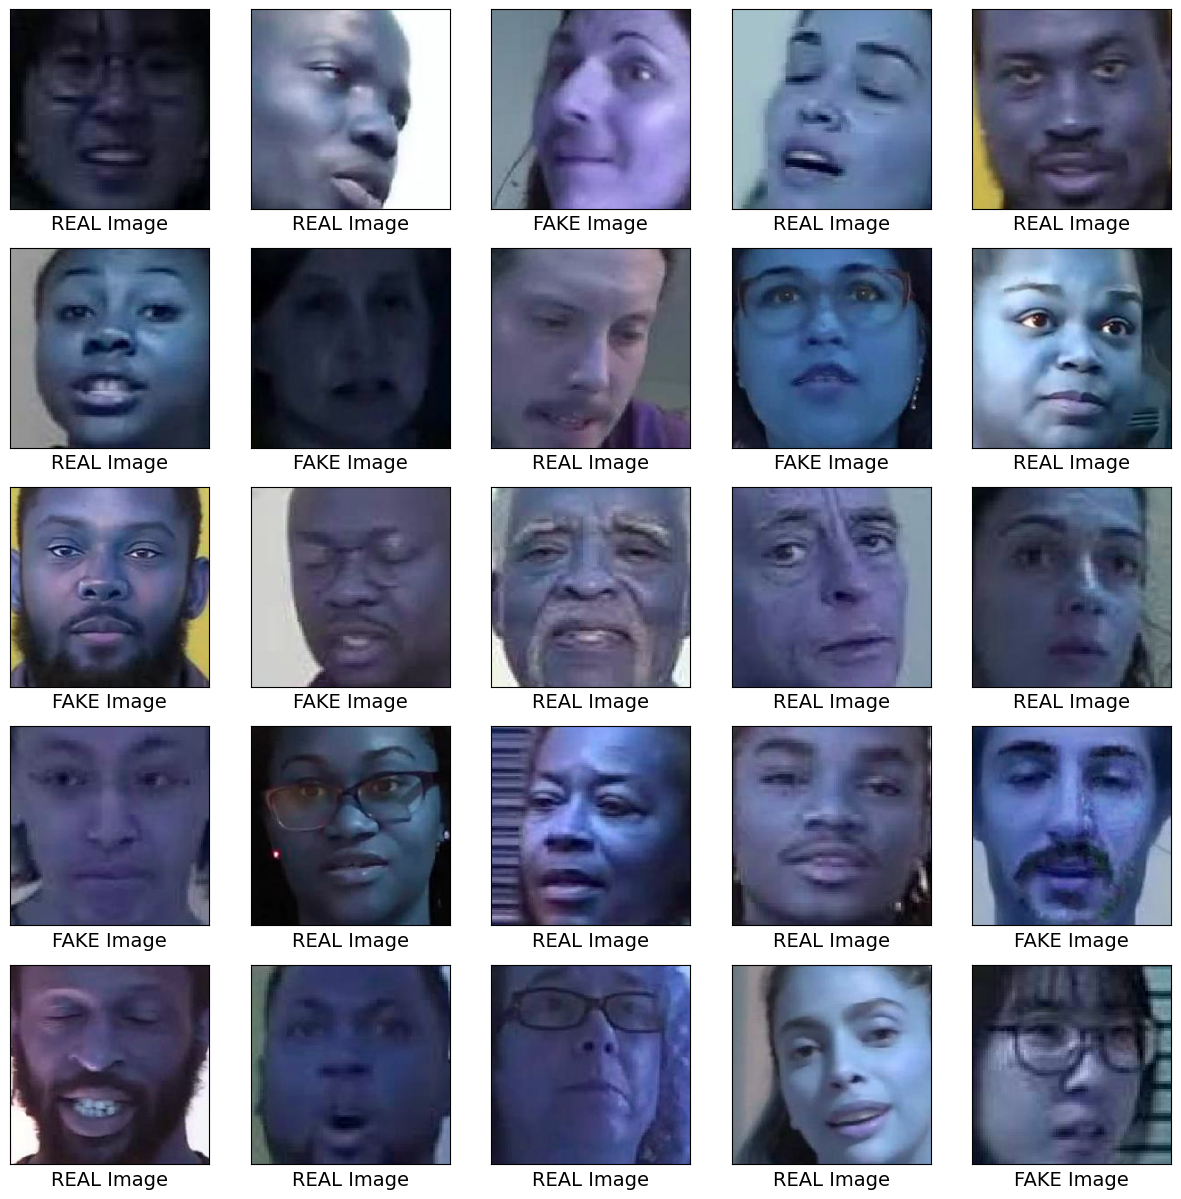

In [ ]:
plt.figure(figsize=(15,15))
for cur,i in enumerate(Train_set.index[25:50]):
    plt.subplot(5,5,cur+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(cv2.imread('faces_224/'+Train_set.loc[i,'videoname'][:-4]+'.jpg'))

    if(Train_set.loc[i,'label']=='FAKE'):
        plt.xlabel('FAKE Image')
    else:
        plt.xlabel('REAL Image')

plt.show()

In [ ]:
def retreive_dataset(set_name):
    images,labels=[],[]
    for (img, imclass) in zip(set_name['videoname'], set_name['label']):
        images.append(cv2.imread('faces_224/'+img[:-4]+'.jpg'))
        if(imclass=='FAKE'):
            labels.append(1)
        else:
            labels.append(0)

    return np.array(images),np.array(labels)

In [ ]:
X_train,y_train=retreive_dataset(Train_set)
X_val,y_val=retreive_dataset(Val_set)
X_test,y_test=retreive_dataset(Test_set)

In [ ]:
train_set_raw=tf.data.Dataset.from_tensor_slices((X_train,y_train))
valid_set_raw=tf.data.Dataset.from_tensor_slices((X_val,y_val))
test_set_raw=tf.data.Dataset.from_tensor_slices((X_test,y_test))

In [ ]:
tf.keras.backend.clear_session()  # extra code – resets layer name counter

batch_size = 32
preprocess = tf.keras.applications.xception.preprocess_input
train_set = train_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y)).batch(batch_size)

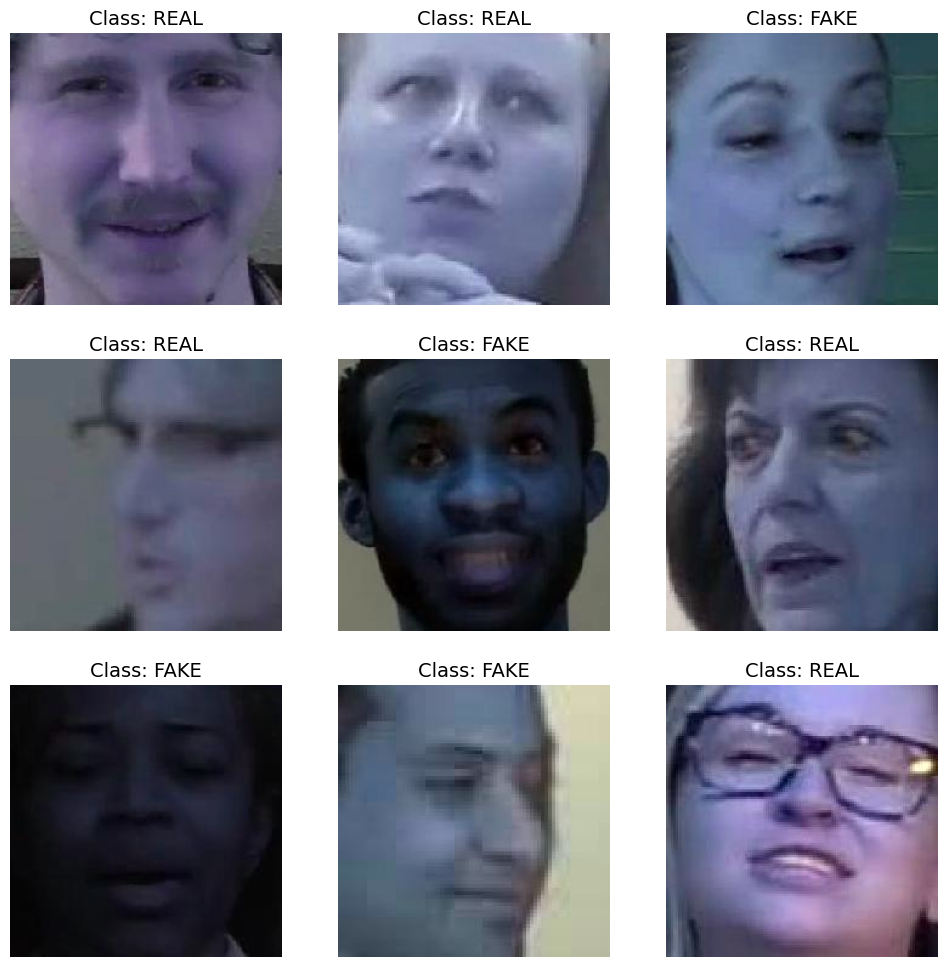

In [ ]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow((X_batch[index] + 1) / 2)  # rescale to 0–1 for imshow()
        if(y_batch[index]==1):
            classt='FAKE'
        else:
            classt='REAL'
        plt.title(f"Class: {classt}")
        plt.axis("off")

plt.show()

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42)
])

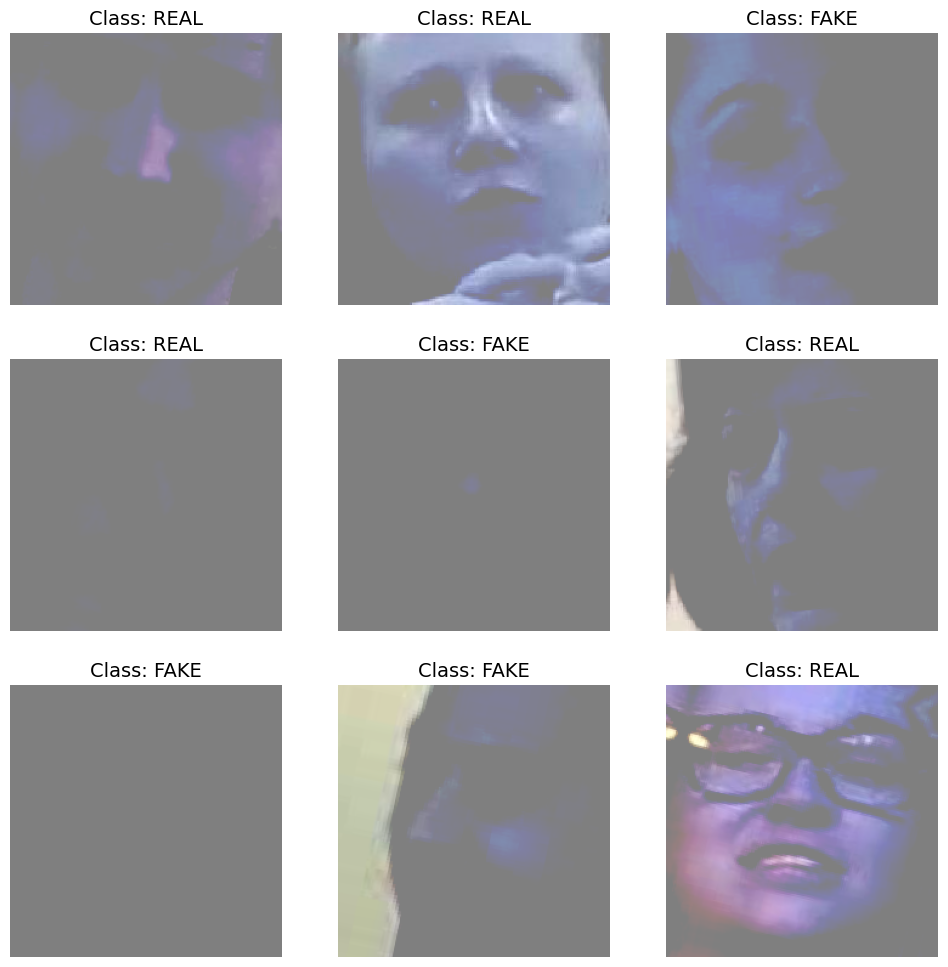

In [ ]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    X_batch_augmented = data_augmentation(X_batch, training=True)
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        # We must rescale the images to the 0-1 range for imshow(), and also
        # clip the result to that range, because data augmentation may
        # make some values go out of bounds (e.g., RandomContrast in this case).
        plt.imshow(np.clip((X_batch_augmented[index] + 1) / 2, 0, 1))
        if(y_batch[index]==1):
            classt='FAKE'
        else:
            classt='REAL'
        plt.title(f"Class: {classt}")
        plt.axis("off")

plt.show()

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(1, activation="sigmoid")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('xception_deepfake_image.h5')

# Print model summary to verify
# model.summary()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


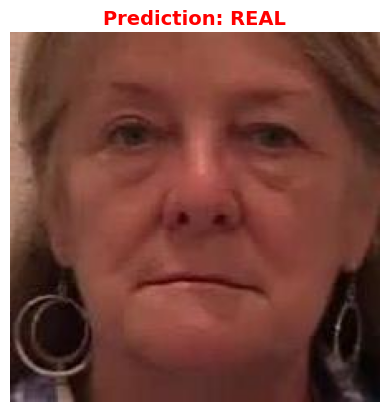

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

# Set the image path (replace with an actual filename)
image_path = 'faces_224/azcdenjart.jpg'  # Change this to a real image file

# Load and preprocess the image
img = image.load_img(image_path, target_size=(224, 224))  # Resize to model's input size
img_array = image.img_to_array(img)  # Convert to NumPy array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize

# Make prediction
prediction = model.predict(img_array)
pred_label = "DEEPFAKE" if prediction[0][0] > 0.5 else "REAL"

# Display image with prediction text
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.title(f"Prediction: {pred_label}", fontsize=14, fontweight="bold", color="red")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


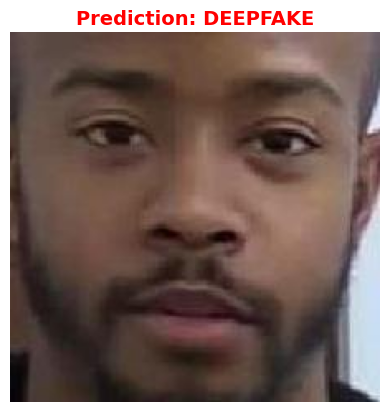

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

# Set the image path (replace with an actual filename)
image_path = 'faces_224/azfdkjyiwz.jpg'  # Change this to a real image file

# Load and preprocess the image
img = image.load_img(image_path, target_size=(224, 224))  # Resize to model's input size
img_array = image.img_to_array(img)  # Convert to NumPy array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize

# Make prediction
prediction = model.predict(img_array)
pred_label = "DEEPFAKE" if prediction[0][0] > 0.5 else "REAL"

# Display image with prediction text
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.title(f"Prediction: {pred_label}", fontsize=14, fontweight="bold", color="red")
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Get true labels and predicted labels
y_true = []
y_pred = []

for images, labels in test_set:  # Loop through test batches
    preds = model.predict(images)  # Get predictions
    preds = (preds > 0.5).astype(int)  # Convert to binary labels (assuming sigmoid activation)

    y_true.extend(labels.numpy())  # Convert to NumPy for evaluation
    y_pred.extend(preds.flatten())  # Flatten predictions

y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 

              precision    recall  f1-score   support

        REAL       0.83      0.79      0.81      1600
        FAKE       0.80      0.83      0.82      1600

    accuracy                           0.81      3200
   macro avg       0.81      0.81      0.81      3200
weighted avg       0.81      0.81      0.81      3200



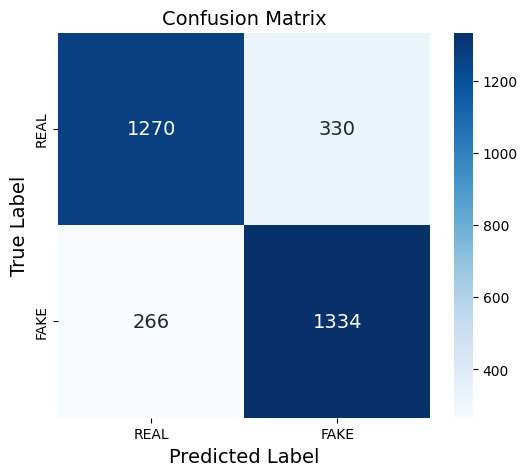

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print classification report (optional)
print(classification_report(y_true, y_pred, target_names=["REAL", "FAKE"]))

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["REAL", "FAKE"], yticklabels=["REAL", "FAKE"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


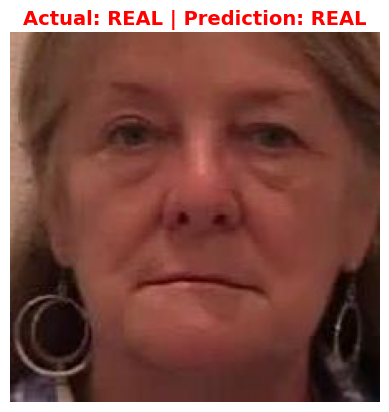

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Load metadata file
meta = pd.read_csv('metadata.csv')

# Set image path (replace with actual file)
image_filename = 'azcdenjart.jpg'
video_name = image_filename.split('.')[0] + '.mp4'  # Convert image name to video name
image_path = f'faces_224/{image_filename}'

# Get the actual label from the metadata using "videoname" column
actual_label_row = meta[meta['videoname'] == video_name]

# Ensure the video exists in metadata
if not actual_label_row.empty:
    actual_label = actual_label_row['label'].values[0]
else:
    actual_label = "Unknown"

# Load and preprocess image
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # Normalize

# Predict the label
prediction = model.predict(img_array)
pred_label = "DEEPFAKE" if prediction[0][0] > 0.5 else "REAL"

# Display image with actual & predicted labels
plt.imshow(img)
plt.axis('off')
plt.title(f"Actual: {actual_label} | Prediction: {pred_label}",
          fontsize=14, fontweight="bold", color="red")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


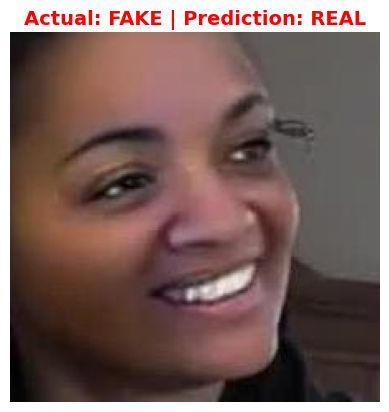

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Load metadata file
meta = pd.read_csv('metadata.csv')

# Set image path (replace with actual file)
image_filename = 'bbkuwgusib.jpg'
video_name = image_filename.split('.')[0] + '.mp4'  # Convert image name to video name
image_path = f'faces_224/{image_filename}'

# Get the actual label from the metadata using "videoname" column
actual_label_row = meta[meta['videoname'] == video_name]

# Ensure the video exists in metadata
if not actual_label_row.empty:
    actual_label = actual_label_row['label'].values[0]
else:
    actual_label = "Unknown"

# Load and preprocess image
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # Normalize

# Predict the label
prediction = model.predict(img_array)
pred_label = "FAKE" if prediction[0][0] > 0.5 else "REAL"

# Display image with actual & predicted labels
plt.imshow(img)
plt.axis('off')
plt.title(f"Actual: {actual_label} | Prediction: {pred_label}",
          fontsize=14, fontweight="bold", color="red")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


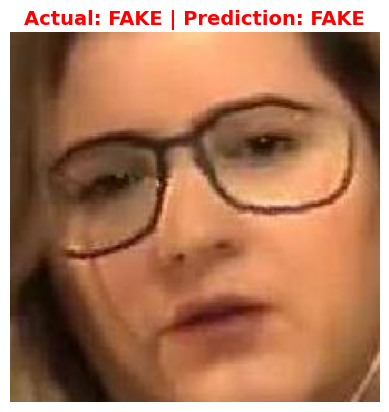

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Load metadata file
meta = pd.read_csv('metadata.csv')

# Set image path (replace with actual file)
image_filename = 'beridjgqtm.jpg'
video_name = image_filename.split('.')[0] + '.mp4'  # Convert image name to video name
image_path = f'faces_224/{image_filename}'

# Get the actual label from the metadata using "videoname" column
actual_label_row = meta[meta['videoname'] == video_name]

# Ensure the video exists in metadata
if not actual_label_row.empty:
    actual_label = actual_label_row['label'].values[0]
else:
    actual_label = "Unknown"

# Load and preprocess image
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # Normalize

# Predict the label
prediction = model.predict(img_array)
pred_label = "FAKE" if prediction[0][0] > 0.5 else "REAL"

# Display image with actual & predicted labels
plt.imshow(img)
plt.axis('off')
plt.title(f"Actual: {actual_label} | Prediction: {pred_label}",
          fontsize=14, fontweight="bold", color="red")
plt.show()
